Process Michilli 10 Subbursts
=====

In [1]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import corrfns

bursts = pd.read_csv('bursts.csv')

# Gaussian 2d Fit Stuff
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0



In [2]:
folder = 'data'
outfolder = 'figures'
sigmax_error = []
sigmay_error = []
angle_error  = []
drift_errors = []
drifts       = []
autocorrs    = []
auto_sigmas  = []
red_chisqs   = []
corredges = [(10, 300)]

for burst, filename, edge in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge']), total=len(bursts['filename']) ):
    if 'gajjar' in filename:
        continue
    if burst != 10:  continue
    
    print('processing {}'.format(filename))

    #junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    #Q, U, V = None, None, None
    
    junk, nchan, nbin, I = [], [], [], []
    with open('{}/{}'.format(folder, filename)) as infile:
        for line in infile:
            junki, nchani, nbini, Ii, _, _, _ = line.split(' ')
            junk.append(junki)
            nchan.append(nchani)
            nbin.append(nbini)
            I.append(Ii)
    junk  = np.array(junk, dtype=float)
    nchan = np.array(nchan, dtype=float)
    nbin  = np.array(nbin, dtype=float)
    I     = np.array(I, dtype=float)
    
    n = len(junk)
    edge = int(edge)
    print("Data loaded")
    
    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    tmin = 500 
    tmax = 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :

            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


        for j in range(tmax+1,binmax+1) :

            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

    #### 2. find autocorrelation 
    burstwindow = intensity[:,edge:edge+frequencymax]

  0%|          | 0/28 [00:00<?, ?it/s]

processing 10_puppi_57747_C0531+33_0558_12568.dm559.72.calibP.RM.DD.ASCII
Data loaded


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


weighted center f: 4591.876295611605 	center channel: 314.3008291914273
weighted center f: 4499.028749145488 	center channel: 254.87839945311237


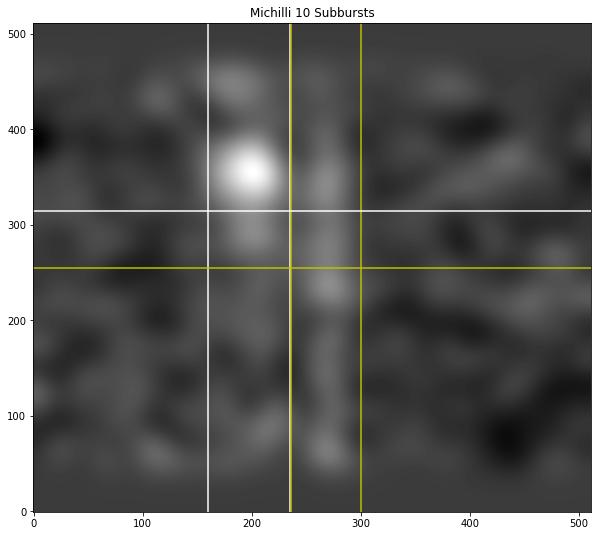

In [5]:
plt.figure(figsize=(10,9))
cmap = plt.get_cmap('gray')
cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
plt.title("Michilli 10 Subbursts")
plt.imshow(gaussian_filter(burstwindow, sigma=15), cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
# plt.clim(0, np.max(burstwindow)/5)

burst10a_edges = [160, 235]
burst10b_edges = [236, 300]

burst10a = burstwindow[:, burst10a_edges[0]:burst10a_edges[1]]
burst10b = burstwindow[:, burst10b_edges[0]:burst10b_edges[1]]

for x in burst10a_edges: plt.axvline(x=x, c='w')
for x in burst10b_edges: plt.axvline(x=x, c='y')
    
chan_width = 1.5625 # MHz
lowestfreq = 4100.78125 # MHz
for freqspectrum, c in zip([burst10a, burst10b], ['w', 'y']):
    freqspectrum = pd.DataFrame(freqspectrum[:,:].sum(axis=1)[:, None])
    data = freqspectrum[:][0]
    x = data.keys()
    xo = sum(x*data)/sum(data)
    plt.axhline(y=xo, c=c)
    print('weighted center f:', xo*chan_width + lowestfreq, '\tcenter channel:', xo)
# plt.savefig('Burst10_partition.png')

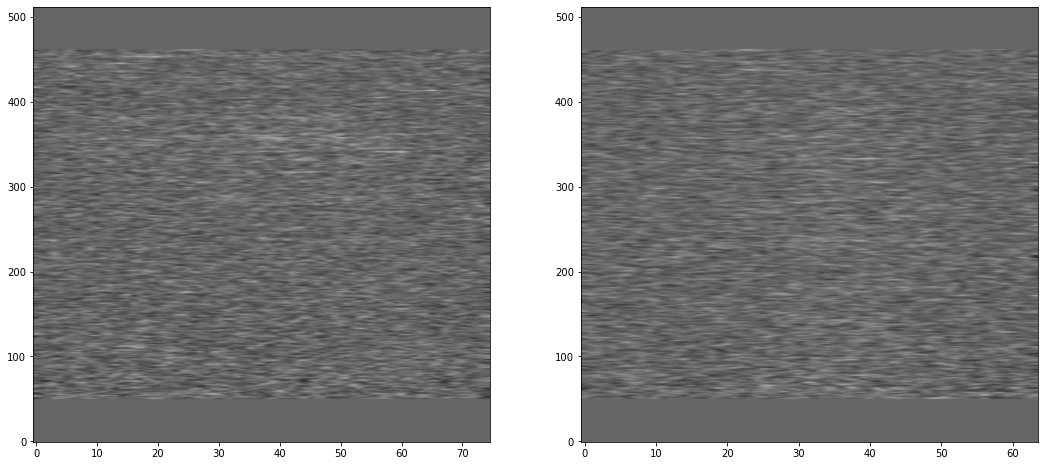

In [4]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(burst10a, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.subplot(122)
plt.imshow(burst10b, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")

In [5]:
    print("finding auto-correlation...")
    #corr = signal.correlate2d(burstwindow, burstwindow, mode='full')
    #print(corr.shape)
    corr = corrfns.auto_corr2D_viafft(burstwindow)
    burst10a_corr = corrfns.auto_corr2D_viafft(burst10a)
    burst10b_corr = corrfns.auto_corr2D_viafft(burst10b)    

finding auto-correlation...


B:\dev\sadtrombone\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]


In [6]:
    def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
        x, y = point
        xo = float(xo)
        yo = float(yo)
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
        return g.ravel()

    def fitgaussiannlsq(data, sigma=0):
        # use curve-fit (non-linear leastsq)
        x = range(0, data.shape[1]); y = range(0, data.shape[0])
        x, y = np.meshgrid(x, y)
        params = moments(data)#+ (0.,)
        sigma = np.zeros(len(data.ravel())) + sigma
        popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (y, x), data.ravel(), p0=params, sigma=sigma, absolute_sigma=True)
        return popt, pcov

    #### 2.5 Autocorr noise
    autocorr_sigma = np.std( corr[:, corredges[0][0]:corredges[0][1]] )
    print('autocorr_sigma', autocorr_sigma)
    auto_sigmas.append(autocorr_sigma)

    #### 3. Fit Gaussian to autocorrelation
    print("finding fit...")
    popt, pcov = fitgaussiannlsq(corr, sigma=autocorr_sigma)
    popt10a, pcov10a = fitgaussiannlsq(burst10a_corr, sigma=autocorr_sigma)
    popt10b, pcov10b = fitgaussiannlsq(burst10b_corr, sigma=autocorr_sigma) 

    perr = np.sqrt(np.diag(pcov))
    perr10a = np.sqrt(np.diag(pcov10a))
    perr10b = np.sqrt(np.diag(pcov10b))
    print('solution nlsq:', popt)
    print('solution nlsq:', popt10a)
    print('solution nlsq:', popt10b)
    # print('parameter 1sigma:', perr)
    # print('pcov diag:', np.diag(pcov))
    # with np.printoptions(precision=3, suppress=True):
        # print('pcov:')
        # print(pcov)

autocorr_sigma 3.8600303309016804
finding fit...
solution nlsq: [  5.79375117 512.93456924 512.44500067  47.05197301 131.21339457
   1.38981522]
solution nlsq: [  5.57454572 512.59734248  75.48705999 106.04951852 -21.38306657
  31.36868964]
solution nlsq: [  3.8714316  514.20524553  64.46501343 169.89914844  -8.80455495
  72.24688719]


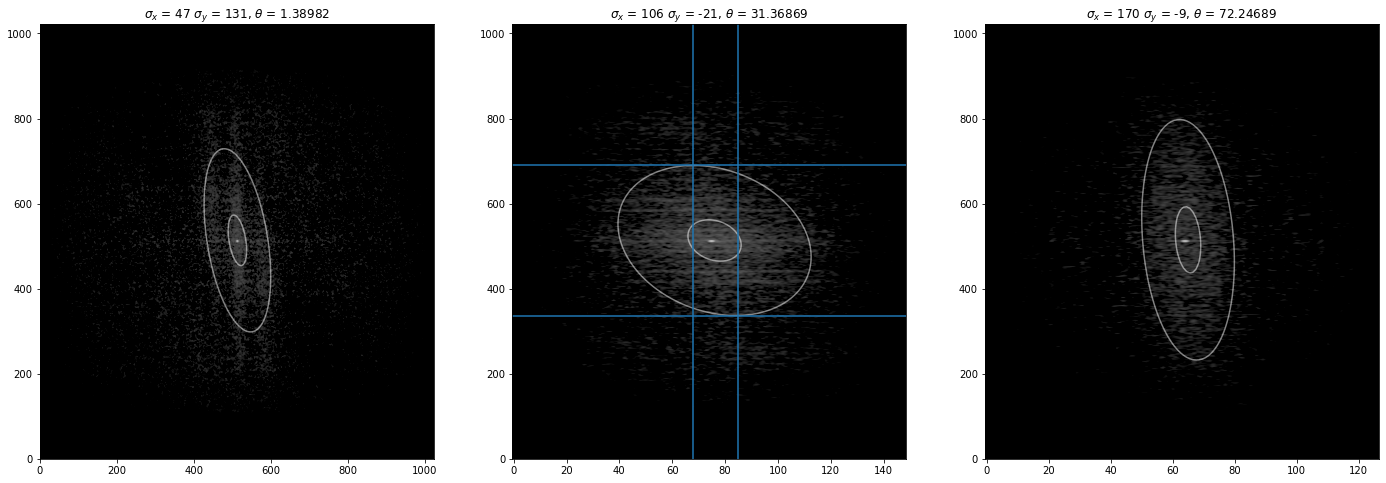

In [19]:
    # Plot and reduced chisquare
    aspect = 'auto'
    plt.figure(figsize=(24,8))
    plt.subplot(131)
    plt.title("$\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(popt[3], popt[4], popt[5]))
    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1))
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower')
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    
    plt.subplot(132)
    plt.title("$\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(popt10a[3], popt10a[4], popt10a[5]))
    x, y = np.meshgrid(range(0, burst10a_corr.shape[1]), range(0, burst10a_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt10a).reshape(burst10a_corr.shape[0], burst10a_corr.shape[1])
    plt.imshow(burst10a_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1))
    plt.contour(fitmap, [popt10a[0]/4, popt10a[0]*0.9], colors='w', alpha=0.5, origin='lower')
    plt.axvline(x=68)
    plt.axhline(y=690)
    plt.axvline(x=85)
    plt.axhline(y=336)
    residuals = burst10a_corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq10a = chisq / (burst10a_corr.shape[0]*burst10a_corr.shape[1] - len(popt)) # this is chisq/(M-N)
    
    plt.subplot(133)
    plt.title("$\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(popt10b[3], popt10b[4], popt10b[5]))
    x, y = np.meshgrid(range(0, burst10b_corr.shape[1]), range(0, burst10b_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt10b).reshape(burst10b_corr.shape[0], burst10b_corr.shape[1])
    plt.imshow(burst10b_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1))
    plt.contour(fitmap, [popt10b[0]/4, popt10b[0]*0.9], colors='w', alpha=0.5, origin='lower')
    residuals = burst10b_corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq10b = chisq / (burst10b_corr.shape[0]*burst10b_corr.shape[1] - len(popt)) # this is chisq/(M-N)
    

1.6180332226928282


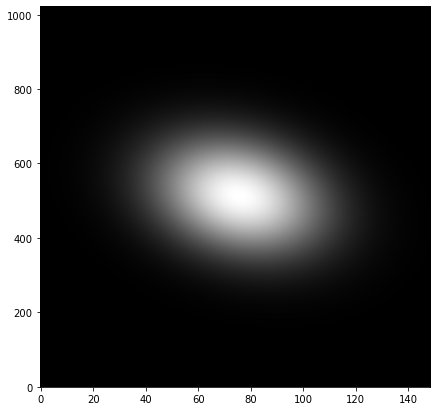

In [11]:
    plt.figure(figsize=(7,7))
    x, y = np.meshgrid(range(0, burst10a_corr.shape[1]), range(0, burst10a_corr.shape[0]))
    testtheta = 6.235948411281655
    print((np.pi/2 - testtheta)% (np.pi*2))
    opts = [5.57454572, 512.59734248, 75.48705999, 106.04951852, -21.38306657, testtheta]
    fitmap = twoD_Gaussian((y, x), *opts).reshape(burst10a_corr.shape[0], burst10a_corr.shape[1])
    plt.imshow(fitmap, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")

In [31]:
    ### 3.5 Compute drift and error
    angles = np.array([popt[-1], popt10a[-1], popt10b[-1]])
    # thetas = (np.pi/2 - np.array([popt[-1] + np.pi/2, popt10a[-1], popt10b[-1]])) % (2*np.pi) 
    thetas = (np.pi/2 - np.array([popt[-1] - np.pi/2,   popt10a[-1],   popt10b[-1]])) % (2*np.pi)
    thetas[-1] = thetas[-1] - np.pi
    theta_errs = np.array([perr[-1], perr10a[-1], perr10b[-1]])
    sigmax_errors = np.array([perr[3], perr10a[3], perr10b[3]])
    sigmay_errors = np.array([perr[4], perr10a[4], perr10b[4]])
    slopes = np.tan(thetas)
    
    chan_width = 1.5625 # MHz
    time_resolution = 0.01024 / 1e3 # ms
    conversion = chan_width / (time_resolution * 1e3)
    drifts = conversion * slopes # MHz/ms
    drift_errors = conversion * (theta_errs * (1/np.cos(thetas))**2)

    print('angles:', angles)
    print('thetas:', thetas)
    print('slopes:', slopes)
    print('drift:', drifts)
    print('drift error:', drift_errors)
    driftresults = pd.DataFrame({
        'angle': angles,
        'theta': thetas,
        'slope': slopes,
        'drift(MHz/ms)': drifts,
        'drift error': drift_errors,
        'sigmax'     : [popt[3], popt10a[3], popt10b[3]],
        'sigmay'     : [popt[4], popt10a[4], popt10b[4]],
        'sigmax_error': sigmax_errors,
        'sigmay_error': sigmay_errors,
        'angle_error': theta_errs,
        'red_chisq'  : [red_chisq, red_chisq10a, red_chisq10b]
    }, index=['10','10a','10b'])

driftresults

angles: [ 1.38981522 31.36868964 72.24688719]
thetas: [1.75177743 1.61803322 1.58054017]
slopes: [  -5.46497946  -21.15414377 -102.62570087]
drift: [  -833.88968843  -3227.8661759  -15659.43921943]
drift error: [  18.56003013  235.93411999 2430.07464869]


,angle,theta,slope,drift(MHz/ms),drift error,sigmax,sigmay,sigmax_error,sigmay_error,angle_error,red_chisq
10,1.389815,1.751777,-5.464979,-833.889688,18.560030,47.051973,131.213395,0.318242,0.886865,0.003941,3.375381
10a,31.368690,1.618033,-21.154144,-3227.866176,235.934120,106.049519,-21.383067,1.230755,0.248140,0.003448,0.525437
10b,72.246887,1.580540,-102.625701,-15659.439219,2430.074649,169.899148,-8.804555,3.501261,0.181120,0.001512,0.421647


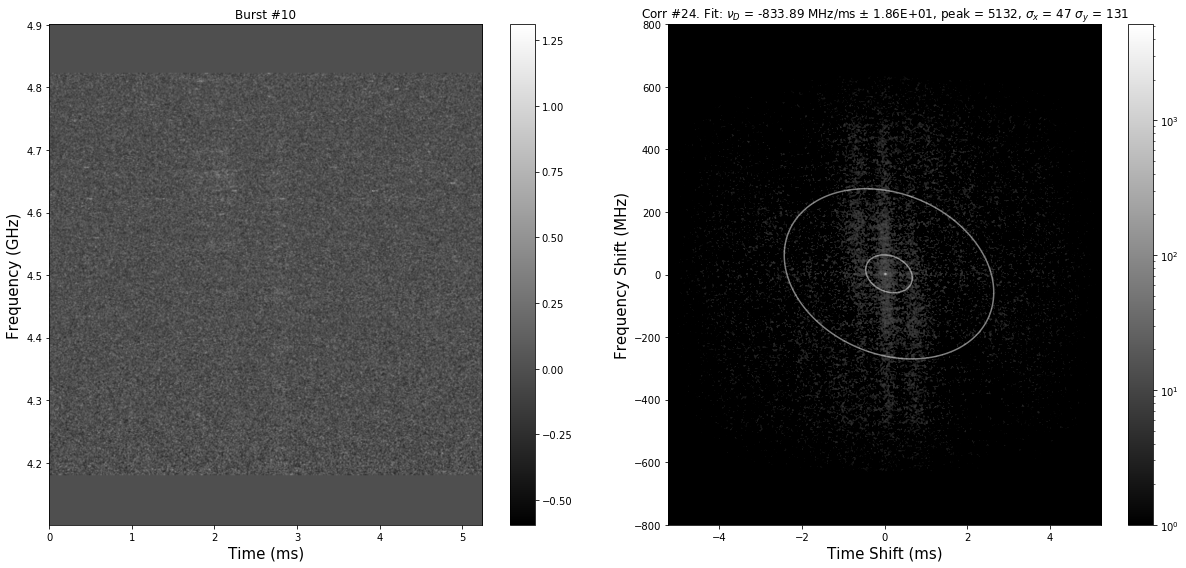

In [13]:
    chan_width = 1.5625 # MHz
    time_resolution = 0.01024 / 1e3 # s
    lowestfreq = 4100.78125 # MHz

    burstextents = [0, 
       time_resolution * burstwindow.shape[1] * 1e3, 
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    burst10aextents = [time_resolution * burst10a_edges[0] * 1e3, 
       time_resolution * burst10a_edges[1] * 1e3, 
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    burst10bextents = [time_resolution * burst10b_edges[0] * 1e3, 
       time_resolution * burst10b_edges[1] * 1e3, 
       lowestfreq * 1e-3, # freq, GHz
       (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    
    corrextents = [-time_resolution * (corr.shape[1]/2) * 1e3, 
       time_resolution * (corr.shape[1]/2) * 1e3 , 
       (lowestfreq -  (2*lowestfreq + chan_width*burstwindow.shape[0])/2 )*2, 
       ((lowestfreq + chan_width*burstwindow.shape[-2]) -  (2*lowestfreq + chan_width*burstwindow.shape[0])/2 )*2]
    corr10aextents = [-time_resolution * (burst10a_corr.shape[1]/2) * 1e3, 
           time_resolution * (burst10a_corr.shape[1]/2) * 1e3 , 
           corrextents[2],
           corrextents[3]]
    corr10bextents = [-time_resolution * (burst10b_corr.shape[1]/2) * 1e3, 
           time_resolution * (burst10b_corr.shape[1]/2) * 1e3 , 
           corrextents[2],
           corrextents[3],]
    
    #### 4. Plot
    cmap = plt.get_cmap('gray')
    cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!

    plt.figure(figsize=(17,8))
    plt.subplot(121)
    plt.title("Burst #{}".format(10))
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.colorbar()

    plt.subplot(122)
    plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drifts[0], drift_errors[0], np.max(corr), popt[3], popt[4]))
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.colorbar()   
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

    plt.tight_layout()
    # plt.savefig('{}/burst_{}_figure.png'.format(outfolder, burst))
    # print('saved {}/burst_{}_figure.png'.format(outfolder, burst))

149
0.01024
0.17408


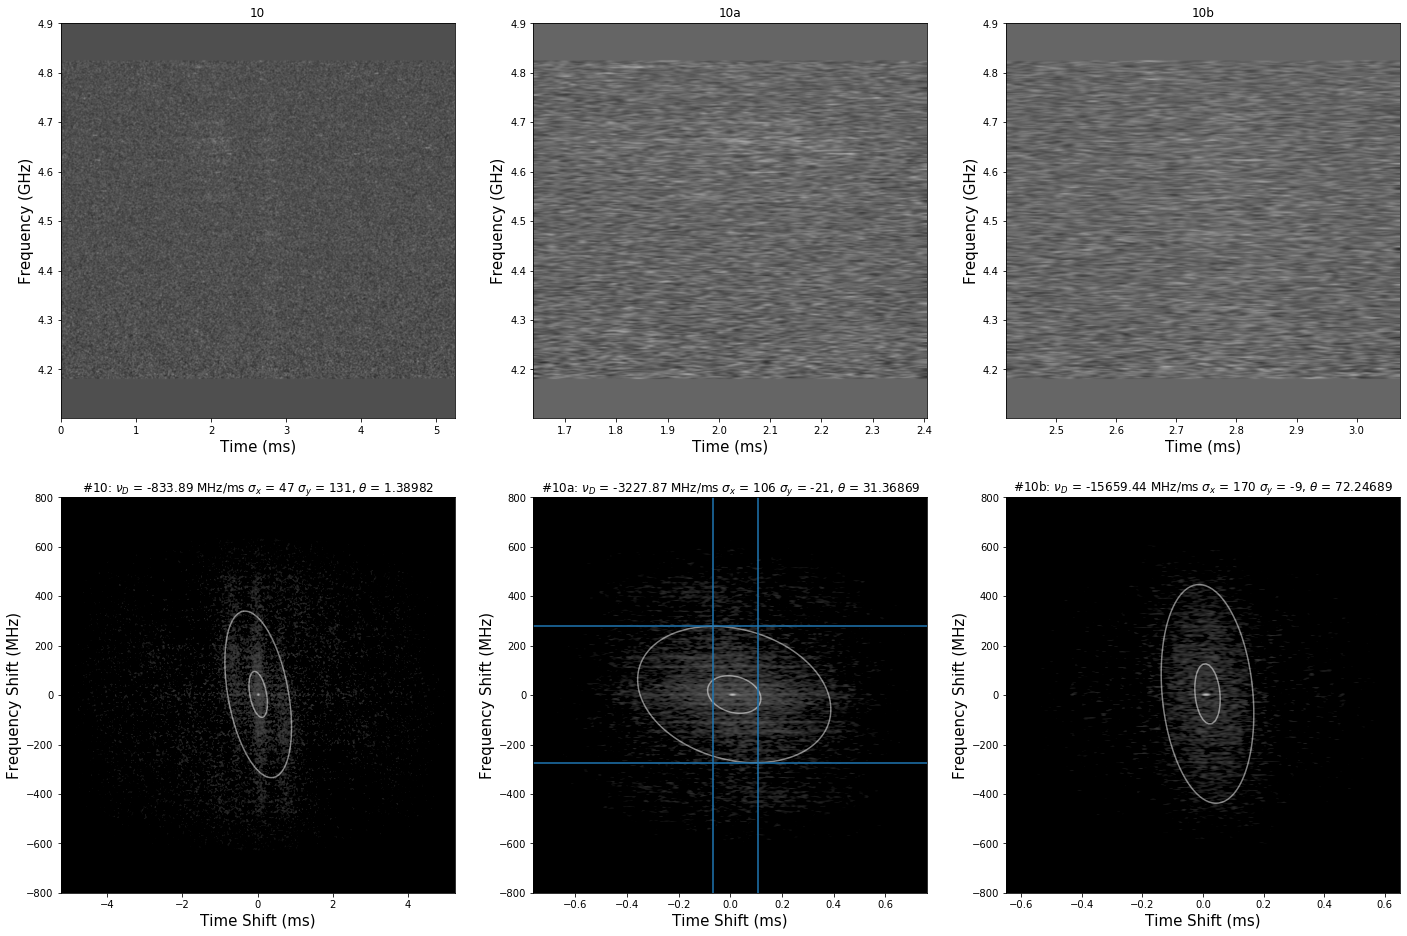

In [33]:
    # Plot 
    aspect = 'auto'
    plt.figure(figsize=(24,16))
    plt.subplot(231)
    plt.title('10')
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect=aspect, origin="lower", extent=burstextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.subplot(232)
    plt.title('10a')
    plt.imshow(burst10a, cmap=cmap, interpolation='bicubic',aspect=aspect, origin="lower", extent=burst10aextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.subplot(233)
    plt.title('10b')
    plt.imshow(burst10b, cmap=cmap, interpolation='bicubic',aspect=aspect, origin="lower", extent=burst10bextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    
    plt.subplot(234)
    plt.title("#10: $\\nu_D$ = {:.2f} MHz/ms $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(drifts[0], popt[3], popt[4], popt[5]))
    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)
    
    plt.subplot(235)
    plt.title("#10a: $\\nu_D$ = {:.2f} MHz/ms $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(drifts[1], popt10a[3], popt10a[4], popt10a[5]))
    x, y = np.meshgrid(range(0, burst10a_corr.shape[1]), range(0, burst10a_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt10a).reshape(burst10a_corr.shape[0], burst10a_corr.shape[1])
    plt.imshow(burst10a_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corr10aextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.contour(fitmap, [popt10a[0]/4, popt10a[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corr10aextents)
    
    print((burst10a_corr.shape[1]))
    print((corr10aextents[1] - corr10aextents[0])/burst10a_corr.shape[1])
    plt.axvline(x=-0.76288000001 + (68)*time_resolution*1e3)
    plt.axhline(y=-800 + 690*chan_width)
    plt.axvline(x=-0.76288000001 + (85)*time_resolution*1e3)
    plt.axhline(y=-800 + 336*chan_width)
    
    print(  (-0.76288000001 + (85)*time_resolution*1e3 - (-0.76288000001 + (68)*time_resolution*1e3)) )
    
    plt.subplot(236)
    plt.title("#10b: $\\nu_D$ = {:.2f} MHz/ms $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}, $\\theta$ = {:.5f}".format(drifts[2], popt10b[3], popt10b[4], popt10b[5]))
    x, y = np.meshgrid(range(0, burst10b_corr.shape[1]), range(0, burst10b_corr.shape[0]))
    fitmap = twoD_Gaussian((y, x), *popt10b).reshape(burst10b_corr.shape[0], burst10b_corr.shape[1])
    plt.imshow(burst10b_corr, cmap=cmap, interpolation='bicubic', aspect=aspect, origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corr10bextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.contour(fitmap, [popt10b[0]/4, popt10b[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corr10bextents)
    plt.savefig('Burst10Subbursts.png')

In [ ]:
print(burst10aextents, corr10aextents)
print(burst10bextents, corr10bextents)
print(burstextents, corrextents)


In [ ]:
print(np.array(burst10a_edges)*time_resolution)
print(np.array(burst10b_edges)*time_resolution)